# Table of Contents
* [1. DDoS Detection on IoT - Unique Model - L5](#1.-DDoS-Detection-on-IoT---Unique-Model---L5)
	* [1.1 Imports](#1.1-Imports)
* [2. Import Datasets and Normalize](#2.-Import-Datasets-and-Normalize)
	* [2.1 Danmini Doorbell](#2.1-Danmini-Doorbell)
	* [2.2 Ecobee Thermostat](#2.2-Ecobee-Thermostat)
	* [2.3 Ennio Doorbell](#2.3-Ennio-Doorbell)
	* [2.4 Philips Baby Monitor](#2.4-Philips-Baby-Monitor)
	* [2.5 Security Camera](#2.5-Security-Camera)
	* [2.6 Security Camera](#2.6-Security-Camera)
	* [2.7 Security Camera](#2.7-Security-Camera)
	* [2.8 Security Camera](#2.8-Security-Camera)
	* [2.9 Samsung Webcam](#2.9-Samsung-Webcam)
* [3. Variational Autoencoder - Attack Detection](#3.-Variational-Autoencoder---Attack-Detection)
	* [3.1 Model](#3.1-Model)
	* [3.2 Train](#3.2-Train)
	* [3.3 Test](#3.3-Test)
	* [3.4 Metrics](#3.4-Metrics)


# 1. DDoS Detection on IoT - Unique Model - L5 - 23 Features - LSTM

## 1.1 Imports

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
os.environ["TF_CUDNN_USE_AUTOTUNE"]="0"

import numpy as np
np.random.seed(2023)

import random as rn
rn.seed(2023)

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
import time

import tensorflow as tf
tf.random.set_seed(2023)
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import seaborn as sns
# sns.set(color_codes=True)

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

import json, codecs

2023-06-22 09:42:11.696610: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 09:42:11.742599: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 09:42:11.743768: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 09:42:12.784296: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 2. Import Datasets and Normalize

## 2.1 Danmini Doorbell

In [2]:
# Benign traffic

dd_benign = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_dd_benign = dd_benign.copy(deep=True)

columns = list(df_dd_benign.columns)
chosen_columns = []

for column in columns:
    if column.find('L5') != -1:             # selecionando apenas intervalo L5 (100 ms)
        chosen_columns.append(column)

df_dd_benign = pd.DataFrame(df_dd_benign, columns = chosen_columns)

# Mirai attacks
dd_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_ack = dd_mirai_ack.copy(deep=True)
df_dd_mirai_ack = pd.DataFrame(df_dd_mirai_ack, columns = chosen_columns)

dd_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_scan = dd_mirai_scan.copy(deep=True)
df_dd_mirai_scan = pd.DataFrame(df_dd_mirai_scan, columns = chosen_columns)

dd_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_syn = dd_mirai_syn.copy(deep=True)
df_dd_mirai_syn = pd.DataFrame(df_dd_mirai_syn, columns = chosen_columns)

dd_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_udp = dd_mirai_udp.copy(deep=True)
df_dd_mirai_udp = pd.DataFrame(df_dd_mirai_udp, columns = chosen_columns)

dd_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_udpplain = dd_mirai_udpplain.copy(deep=True)
df_dd_mirai_udpplain = pd.DataFrame(df_dd_mirai_udpplain, columns = chosen_columns)

# Bashlite attacks
dd_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_combo = dd_bashlite_combo.copy(deep=True)
df_dd_bashlite_combo = pd.DataFrame(df_dd_bashlite_combo, columns = chosen_columns)

dd_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_junk = dd_bashlite_junk.copy(deep=True)
df_dd_bashlite_junk = pd.DataFrame(df_dd_bashlite_junk, columns = chosen_columns)

dd_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_scan = dd_bashlite_scan.copy(deep=True)
df_dd_bashlite_scan = pd.DataFrame(df_dd_bashlite_scan, columns = chosen_columns)

dd_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_udp = dd_bashlite_udp.copy(deep=True)
df_dd_bashlite_udp = pd.DataFrame(df_dd_bashlite_udp, columns = chosen_columns)

dd_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_tcp = dd_bashlite_tcp.copy(deep=True)
df_dd_bashlite_tcp = pd.DataFrame(df_dd_bashlite_tcp, columns = chosen_columns)

In [3]:
df_dd_benign.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,H_L5_weight,H_L5_mean,H_L5_variance,HH_L5_weight,HH_L5_mean,HH_L5_std,HH_L5_magnitude,...,HH_jit_L5_weight,HH_jit_L5_mean,HH_jit_L5_variance,HpHp_L5_weight,HpHp_L5_mean,HpHp_L5_std,HpHp_L5_magnitude,HpHp_L5_radius,HpHp_L5_covariance,HpHp_L5_pcc
0,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,60.000000,...,1.000000,1.505662e+09,0.000000e+00,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0
1,1.000000,354.000000,0.000000,1.000000,354.000000,0.000005,1.000000,354.000000,0.002143,354.000000,...,1.000000,4.980575e+00,4.230000e-07,1.000000,354.000000,0.002143,354.000000,0.000005,0.0,0.0
2,1.857879,360.458980,35.789338,1.857879,360.458979,35.789342,1.857879,360.458979,5.982419,360.458979,...,1.857879,2.323596e+00,6.056226e+00,1.857879,360.458979,5.982419,360.458979,35.789342,0.0,0.0
3,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,337.000000,...,1.000000,1.505662e+09,0.000000e+00,1.000000,337.000000,0.000000,337.000000,0.000000,0.0,0.0
4,1.680223,172.140917,18487.448750,1.680223,172.140917,18487.448750,1.000000,60.000000,0.000000,524.399648,...,1.000000,1.505662e+09,0.000000e+00,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0


In [4]:
scaler = MinMaxScaler()

df_dd_benign_norm = scaler.fit_transform(df_dd_benign)
df_dd_miraiack_norm = scaler.fit_transform(df_dd_mirai_ack)
df_dd_miraiscan_norm = scaler.fit_transform(df_dd_mirai_scan)
df_dd_miraisyn_norm = scaler.fit_transform(df_dd_mirai_syn)
df_dd_miraiudp_norm = scaler.fit_transform(df_dd_mirai_udp)
df_dd_miraiudpplain_norm = scaler.fit_transform(df_dd_mirai_udpplain)

df_dd_bashlitecombo_norm = scaler.fit_transform(df_dd_bashlite_combo)
df_dd_bashlitejunk_norm = scaler.fit_transform(df_dd_bashlite_junk)
df_dd_bashlitescan_norm = scaler.fit_transform(df_dd_bashlite_scan)
df_dd_bashliteudp_norm = scaler.fit_transform(df_dd_bashlite_udp)
df_dd_bashlitetcp_norm = scaler.fit_transform(df_dd_bashlite_tcp)

## 2.2 Ecobee Thermostat

In [5]:
# Benign traffic

et_benign = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_et_benign = et_benign.copy(deep=True)
df_et_benign = pd.DataFrame(df_et_benign, columns = chosen_columns)

# Mirai

et_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_ack = et_mirai_ack.copy(deep=True)
df_et_mirai_ack = pd.DataFrame(df_et_mirai_ack, columns = chosen_columns)

et_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_scan = et_mirai_scan.copy(deep=True)
df_et_mirai_scan = pd.DataFrame(df_et_mirai_scan, columns = chosen_columns)

et_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_syn = et_mirai_syn.copy(deep=True)
df_et_mirai_syn = pd.DataFrame(df_et_mirai_syn, columns = chosen_columns)

et_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_udp = et_mirai_udp.copy(deep=True)
df_et_mirai_udp = pd.DataFrame(df_et_mirai_udp, columns = chosen_columns)

et_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_udpplain = et_mirai_udpplain.copy(deep=True)
df_et_mirai_udpplain = pd.DataFrame(df_et_mirai_udpplain, columns = chosen_columns)

# Bashlite

et_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_combo = et_bashlite_combo.copy(deep=True)
df_et_bashlite_combo = pd.DataFrame(df_et_bashlite_combo, columns = chosen_columns)

et_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_junk = et_bashlite_junk.copy(deep=True)
df_et_bashlite_junk = pd.DataFrame(df_et_bashlite_junk, columns = chosen_columns)

et_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_scan = et_bashlite_scan.copy(deep=True)
df_et_bashlite_scan = pd.DataFrame(df_et_bashlite_scan, columns = chosen_columns)

et_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_udp = et_bashlite_udp.copy(deep=True)
df_et_bashlite_udp = pd.DataFrame(df_et_bashlite_udp, columns = chosen_columns)

et_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_tcp = et_bashlite_tcp.copy(deep=True)
df_et_bashlite_tcp = pd.DataFrame(df_et_bashlite_tcp, columns = chosen_columns)

In [6]:
df_et_benign_norm = scaler.fit_transform(df_et_benign)

df_et_miraiack_norm = scaler.fit_transform(df_et_mirai_ack)
df_et_miraiscan_norm = scaler.fit_transform(df_et_mirai_scan)
df_et_miraisyn_norm = scaler.fit_transform(df_et_mirai_syn)
df_et_miraiudp_norm = scaler.fit_transform(df_et_mirai_udp)
df_et_miraiudpplain_norm = scaler.fit_transform(df_et_mirai_udpplain)

df_et_bashlitecombo_norm = scaler.fit_transform(df_et_bashlite_combo)
df_et_bashlitejunk_norm = scaler.fit_transform(df_et_bashlite_junk)
df_et_bashlitescan_norm = scaler.fit_transform(df_et_bashlite_scan)
df_et_bashliteudp_norm = scaler.fit_transform(df_et_bashlite_udp)
df_et_bashlitetcp_norm = scaler.fit_transform(df_et_bashlite_tcp)

## 2.3 Ennio Doorbell

In [7]:
# Benign traffic

ed_benign = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ennio_Doorbell/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_ed_benign = ed_benign.copy(deep=True)
df_ed_benign = pd.DataFrame(df_ed_benign, columns = chosen_columns)

# Only Bashlite

ed_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ennio_Doorbell/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_combo = ed_bashlite_combo.copy(deep=True)
df_ed_bashlite_combo = pd.DataFrame(df_ed_bashlite_combo, columns = chosen_columns)

ed_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ennio_Doorbell/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_junk = ed_bashlite_junk.copy(deep=True)
df_ed_bashlite_junk = pd.DataFrame(df_ed_bashlite_junk, columns = chosen_columns)

ed_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ennio_Doorbell/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_scan = ed_bashlite_scan.copy(deep=True)
df_ed_bashlite_scan = pd.DataFrame(df_ed_bashlite_scan, columns = chosen_columns)

ed_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ennio_Doorbell/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_udp = ed_bashlite_udp.copy(deep=True)
df_ed_bashlite_udp = pd.DataFrame(df_ed_bashlite_udp, columns = chosen_columns)

ed_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ennio_Doorbell/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_tcp = ed_bashlite_tcp.copy(deep=True)
df_ed_bashlite_tcp = pd.DataFrame(df_ed_bashlite_tcp, columns = chosen_columns)

In [8]:
df_ed_benign_norm = scaler.fit_transform(df_ed_benign)

df_ed_bashlitecombo_norm = scaler.fit_transform(df_ed_bashlite_combo)
df_ed_bashlitejunk_norm = scaler.fit_transform(df_ed_bashlite_junk)
df_ed_bashlitescan_norm = scaler.fit_transform(df_ed_bashlite_scan)
df_ed_bashliteudp_norm = scaler.fit_transform(df_ed_bashlite_udp)
df_ed_bashlitetcp_norm = scaler.fit_transform(df_ed_bashlite_tcp)

## 2.4 Philips Baby Monitor

In [9]:
# Benign traffic

pb_benign = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_pb_benign = pb_benign.copy(deep=True)
df_pb_benign = pd.DataFrame(df_pb_benign, columns = chosen_columns)        
        
# Mirai

pb_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_ack = pb_mirai_ack.copy(deep=True)
df_pb_mirai_ack = pd.DataFrame(df_pb_mirai_ack, columns = chosen_columns)

pb_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_scan = pb_mirai_scan.copy(deep=True)
df_pb_mirai_scan = pd.DataFrame(df_pb_mirai_scan, columns = chosen_columns)

pb_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_syn = pb_mirai_syn.copy(deep=True)
df_pb_mirai_syn = pd.DataFrame(df_pb_mirai_syn, columns = chosen_columns)

pb_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_udp = pb_mirai_udp.copy(deep=True)
df_pb_mirai_udp = pd.DataFrame(df_pb_mirai_udp, columns = chosen_columns)

pb_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_udpplain = pb_mirai_udpplain.copy(deep=True)
df_pb_mirai_udpplain = pd.DataFrame(df_pb_mirai_udpplain, columns = chosen_columns)

# Bashlite

pb_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_combo = pb_bashlite_combo.copy(deep=True)
df_pb_bashlite_combo = pd.DataFrame(df_pb_bashlite_combo, columns = chosen_columns)

pb_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_junk = pb_bashlite_junk.copy(deep=True)
df_pb_bashlite_junk = pd.DataFrame(df_pb_bashlite_junk, columns = chosen_columns)

pb_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_scan = pb_bashlite_scan.copy(deep=True)
df_pb_bashlite_scan = pd.DataFrame(df_pb_bashlite_scan, columns = chosen_columns)

pb_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_udp = pb_bashlite_udp.copy(deep=True)
df_pb_bashlite_udp = pd.DataFrame(df_pb_bashlite_udp, columns = chosen_columns)

pb_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_tcp = pb_bashlite_tcp.copy(deep=True)
df_pb_bashlite_tcp = pd.DataFrame(df_pb_bashlite_tcp, columns = chosen_columns)

In [10]:
df_pb_benign_norm = scaler.fit_transform(df_pb_benign)

df_pb_miraiack_norm = scaler.fit_transform(df_pb_mirai_ack)
df_pb_miraiscan_norm = scaler.fit_transform(df_pb_mirai_scan)
df_pb_miraisyn_norm = scaler.fit_transform(df_pb_mirai_syn)
df_pb_miraiudp_norm = scaler.fit_transform(df_pb_mirai_udp)
df_pb_miraiudpplain_norm = scaler.fit_transform(df_pb_mirai_udpplain)

df_pb_bashlitecombo_norm = scaler.fit_transform(df_pb_bashlite_combo)
df_pb_bashlitejunk_norm = scaler.fit_transform(df_pb_bashlite_junk)
df_pb_bashlitescan_norm = scaler.fit_transform(df_pb_bashlite_scan)
df_pb_bashliteudp_norm = scaler.fit_transform(df_pb_bashlite_udp)
df_pb_bashlitetcp_norm = scaler.fit_transform(df_pb_bashlite_tcp)

## 2.5 Security Camera

In [11]:
# Benign traffic

p7_benign = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_p7_benign = p7_benign.copy(deep=True)
df_p7_benign = pd.DataFrame(df_p7_benign, columns = chosen_columns)    

# Mirai

p7_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_ack = p7_mirai_ack.copy(deep=True)
df_p7_mirai_ack = pd.DataFrame(df_p7_mirai_ack, columns = chosen_columns)  

p7_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_scan = p7_mirai_scan.copy(deep=True)
df_p7_mirai_scan = pd.DataFrame(df_p7_mirai_scan, columns = chosen_columns)

p7_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_syn = p7_mirai_syn.copy(deep=True)
df_p7_mirai_syn = pd.DataFrame(df_p7_mirai_syn, columns = chosen_columns)

p7_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_udp = p7_mirai_udp.copy(deep=True)
df_p7_mirai_udp = pd.DataFrame(df_p7_mirai_udp, columns = chosen_columns)

p7_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_udpplain = p7_mirai_udpplain.copy(deep=True)
df_p7_mirai_udpplain = pd.DataFrame(df_p7_mirai_udpplain, columns = chosen_columns)

# Bashlite

p7_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_combo = p7_bashlite_combo.copy(deep=True)
df_p7_bashlite_combo = pd.DataFrame(df_p7_bashlite_combo, columns = chosen_columns)

p7_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_junk = p7_bashlite_junk.copy(deep=True)
df_p7_bashlite_junk = pd.DataFrame(df_p7_bashlite_junk, columns = chosen_columns)

p7_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_scan = p7_bashlite_scan.copy(deep=True)
df_p7_bashlite_scan = pd.DataFrame(df_p7_bashlite_scan, columns = chosen_columns)

p7_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_udp = p7_bashlite_udp.copy(deep=True)
df_p7_bashlite_udp = pd.DataFrame(df_p7_bashlite_udp, columns = chosen_columns)

p7_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_tcp = p7_bashlite_tcp.copy(deep=True)
df_p7_bashlite_tcp = pd.DataFrame(df_p7_bashlite_tcp, columns = chosen_columns)

In [12]:
df_p7_benign_norm = scaler.fit_transform(df_p7_benign)

df_p7_miraiack_norm = scaler.fit_transform(df_p7_mirai_ack)
df_p7_miraiscan_norm = scaler.fit_transform(df_p7_mirai_scan)
df_p7_miraisyn_norm = scaler.fit_transform(df_p7_mirai_syn)
df_p7_miraiudp_norm = scaler.fit_transform(df_p7_mirai_udp)
df_p7_miraiudpplain_norm = scaler.fit_transform(df_p7_mirai_udpplain)

df_p7_bashlitecombo_norm = scaler.fit_transform(df_p7_bashlite_combo)
df_p7_bashlitejunk_norm = scaler.fit_transform(df_p7_bashlite_junk)
df_p7_bashlitescan_norm = scaler.fit_transform(df_p7_bashlite_scan)
df_p7_bashliteudp_norm = scaler.fit_transform(df_p7_bashlite_udp)
df_p7_bashlitetcp_norm = scaler.fit_transform(df_p7_bashlite_tcp)

## 2.6 Security Camera

In [13]:
# Benign traffic

p8_benign = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_p8_benign = p8_benign.copy(deep=True)
df_p8_benign = pd.DataFrame(df_p8_benign, columns = chosen_columns)  

# Mirai

p8_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_ack = p8_mirai_ack.copy(deep=True)
df_p8_mirai_ack = pd.DataFrame(df_p8_mirai_ack, columns = chosen_columns) 

p8_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_scan = p8_mirai_scan.copy(deep=True)
df_p8_mirai_scan = pd.DataFrame(df_p8_mirai_scan, columns = chosen_columns) 

p8_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_syn = p8_mirai_syn.copy(deep=True)
df_p8_mirai_syn = pd.DataFrame(df_p8_mirai_syn, columns = chosen_columns) 

p8_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_udp = p8_mirai_udp.copy(deep=True)
df_p8_mirai_udp = pd.DataFrame(df_p8_mirai_udp, columns = chosen_columns) 

p8_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_udpplain = p8_mirai_udpplain.copy(deep=True)
df_p8_mirai_udpplain = pd.DataFrame(df_p8_mirai_udpplain, columns = chosen_columns) 

# Bashlite

p8_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_combo = p8_bashlite_combo.copy(deep=True)
df_p8_bashlite_combo = pd.DataFrame(df_p8_bashlite_combo, columns = chosen_columns) 

p8_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_junk = p8_bashlite_junk.copy(deep=True)
df_p8_bashlite_junk = pd.DataFrame(df_p8_bashlite_junk, columns = chosen_columns)

p8_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_scan = p8_bashlite_scan.copy(deep=True)
df_p8_bashlite_scan = pd.DataFrame(df_p8_bashlite_scan, columns = chosen_columns)

p8_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_udp = p8_bashlite_udp.copy(deep=True)
df_p8_bashlite_udp = pd.DataFrame(df_p8_bashlite_udp, columns = chosen_columns)

p8_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_tcp = p8_bashlite_tcp.copy(deep=True)
df_p8_bashlite_tcp = pd.DataFrame(df_p8_bashlite_tcp, columns = chosen_columns)

In [14]:
df_p8_benign_norm = scaler.fit_transform(df_p8_benign)

df_p8_miraiack_norm = scaler.fit_transform(df_p8_mirai_ack)
df_p8_miraiscan_norm = scaler.fit_transform(df_p8_mirai_scan)
df_p8_miraisyn_norm = scaler.fit_transform(df_p8_mirai_syn)
df_p8_miraiudp_norm = scaler.fit_transform(df_p8_mirai_udp)
df_p8_miraiudpplain_norm = scaler.fit_transform(df_p8_mirai_udpplain)

df_p8_bashlitecombo_norm = scaler.fit_transform(df_p8_bashlite_combo)
df_p8_bashlitejunk_norm = scaler.fit_transform(df_p8_bashlite_junk)
df_p8_bashlitescan_norm = scaler.fit_transform(df_p8_bashlite_scan)
df_p8_bashliteudp_norm = scaler.fit_transform(df_p8_bashlite_udp)
df_p8_bashlitetcp_norm = scaler.fit_transform(df_p8_bashlite_tcp)

## 2.7 Security Camera

In [15]:
# Benign traffic

s2_benign = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_s2_benign = s2_benign.copy(deep=True)
df_s2_benign = pd.DataFrame(df_s2_benign, columns = chosen_columns)  

# Mirai

s2_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_ack = s2_mirai_ack.copy(deep=True)
df_s2_mirai_ack = pd.DataFrame(df_s2_mirai_ack, columns = chosen_columns)

s2_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_scan = s2_mirai_scan.copy(deep=True)
df_s2_mirai_scan = pd.DataFrame(df_s2_mirai_scan, columns = chosen_columns)

s2_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_syn = s2_mirai_syn.copy(deep=True)
df_s2_mirai_syn = pd.DataFrame(df_s2_mirai_syn, columns = chosen_columns)

s2_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_udp = s2_mirai_udp.copy(deep=True)
df_s2_mirai_udp = pd.DataFrame(df_s2_mirai_udp, columns = chosen_columns)

s2_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_udpplain = s2_mirai_udpplain.copy(deep=True)
df_s2_mirai_udpplain = pd.DataFrame(df_s2_mirai_udpplain, columns = chosen_columns)

# Bashlite

s2_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_combo = s2_bashlite_combo.copy(deep=True)
df_s2_bashlite_combo = pd.DataFrame(df_s2_bashlite_combo, columns = chosen_columns)

s2_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_junk = s2_bashlite_junk.copy(deep=True)
df_s2_bashlite_junk = pd.DataFrame(df_s2_bashlite_junk, columns = chosen_columns)

s2_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_scan = s2_bashlite_scan.copy(deep=True)
df_s2_bashlite_scan = pd.DataFrame(df_s2_bashlite_scan, columns = chosen_columns)

s2_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_udp = s2_bashlite_udp.copy(deep=True)
df_s2_bashlite_udp = pd.DataFrame(df_s2_bashlite_udp, columns = chosen_columns)

s2_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_tcp = s2_bashlite_tcp.copy(deep=True)
df_s2_bashlite_tcp = pd.DataFrame(df_s2_bashlite_tcp, columns = chosen_columns)

In [16]:
df_s2_benign_norm = scaler.fit_transform(df_s2_benign)

df_s2_miraiack_norm = scaler.fit_transform(df_s2_mirai_ack)
df_s2_miraiscan_norm = scaler.fit_transform(df_s2_mirai_scan)
df_s2_miraisyn_norm = scaler.fit_transform(df_s2_mirai_syn)
df_s2_miraiudp_norm = scaler.fit_transform(df_s2_mirai_udp)
df_s2_miraiudpplain_norm = scaler.fit_transform(df_s2_mirai_udpplain)

df_s2_bashlitecombo_norm = scaler.fit_transform(df_s2_bashlite_combo)
df_s2_bashlitejunk_norm = scaler.fit_transform(df_s2_bashlite_junk)
df_s2_bashlitescan_norm = scaler.fit_transform(df_s2_bashlite_scan)
df_s2_bashliteudp_norm = scaler.fit_transform(df_s2_bashlite_udp)
df_s2_bashlitetcp_norm = scaler.fit_transform(df_s2_bashlite_tcp)

## 2.8 Security Camera

In [17]:
# Benign traffic

s3_benign = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_s3_benign = s3_benign.copy(deep=True)
df_s3_benign = pd.DataFrame(df_s3_benign, columns = chosen_columns)

# Mirai

s3_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_ack = s3_mirai_ack.copy(deep=True)
df_s3_mirai_ack = pd.DataFrame(df_s3_mirai_ack, columns = chosen_columns)

s3_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_scan = s3_mirai_scan.copy(deep=True)
df_s3_mirai_scan = pd.DataFrame(df_s3_mirai_scan, columns = chosen_columns)

s3_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_syn = s3_mirai_syn.copy(deep=True)
df_s3_mirai_syn = pd.DataFrame(df_s3_mirai_syn, columns = chosen_columns)

s3_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_udp = s3_mirai_udp.copy(deep=True)
df_s3_mirai_udp = pd.DataFrame(df_s3_mirai_udp, columns = chosen_columns)

s3_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_udpplain = s3_mirai_udpplain.copy(deep=True)
df_s3_mirai_udpplain = pd.DataFrame(df_s3_mirai_udpplain, columns = chosen_columns)

# Bashlite

s3_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_combo = s3_bashlite_combo.copy(deep=True)
df_s3_bashlite_combo = pd.DataFrame(df_s3_bashlite_combo, columns = chosen_columns)

s3_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_junk = s3_bashlite_junk.copy(deep=True)
df_s3_bashlite_junk = pd.DataFrame(df_s3_bashlite_junk, columns = chosen_columns)

s3_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_scan = s3_bashlite_scan.copy(deep=True)
df_s3_bashlite_scan = pd.DataFrame(df_s3_bashlite_scan, columns = chosen_columns)

s3_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_udp = s3_bashlite_udp.copy(deep=True)
df_s3_bashlite_udp = pd.DataFrame(df_s3_bashlite_udp, columns = chosen_columns)

s3_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_tcp = s3_bashlite_tcp.copy(deep=True)
df_s3_bashlite_tcp = pd.DataFrame(df_s3_bashlite_tcp, columns = chosen_columns)

In [18]:
df_s3_benign_norm = scaler.fit_transform(df_s3_benign)

df_s3_miraiack_norm = scaler.fit_transform(df_s3_mirai_ack)
df_s3_miraiscan_norm = scaler.fit_transform(df_s3_mirai_scan)
df_s3_miraisyn_norm = scaler.fit_transform(df_s3_mirai_syn)
df_s3_miraiudp_norm = scaler.fit_transform(df_s3_mirai_udp)
df_s3_miraiudpplain_norm = scaler.fit_transform(df_s3_mirai_udpplain)

df_s3_bashlitecombo_norm = scaler.fit_transform(df_s3_bashlite_combo)
df_s3_bashlitejunk_norm = scaler.fit_transform(df_s3_bashlite_junk)
df_s3_bashlitescan_norm = scaler.fit_transform(df_s3_bashlite_scan)
df_s3_bashliteudp_norm = scaler.fit_transform(df_s3_bashlite_udp)
df_s3_bashlitetcp_norm = scaler.fit_transform(df_s3_bashlite_tcp)

## 2.9 Samsung Webcam

In [19]:
# Benign traffic

sw_benign = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Samsung_SNH_1011_N_Webcam/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_sw_benign = sw_benign.copy(deep=True)
df_sw_benign = pd.DataFrame(df_sw_benign, columns = chosen_columns)

# Bashlite Only

sw_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_combo = sw_bashlite_combo.copy(deep=True)
df_sw_bashlite_combo = pd.DataFrame(df_sw_bashlite_combo, columns = chosen_columns)

sw_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_junk = sw_bashlite_junk.copy(deep=True)
df_sw_bashlite_junk = pd.DataFrame(df_sw_bashlite_junk, columns = chosen_columns)

sw_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_scan = sw_bashlite_scan.copy(deep=True)
df_sw_bashlite_scan = pd.DataFrame(df_sw_bashlite_scan, columns = chosen_columns)

sw_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_udp = sw_bashlite_udp.copy(deep=True)
df_sw_bashlite_udp = pd.DataFrame(df_sw_bashlite_udp, columns = chosen_columns)

sw_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_tcp = sw_bashlite_tcp.copy(deep=True)
df_sw_bashlite_tcp = pd.DataFrame(df_sw_bashlite_tcp, columns = chosen_columns)

In [20]:
df_sw_benign_norm = scaler.fit_transform(df_sw_benign)

df_sw_bashlitecombo_norm = scaler.fit_transform(df_sw_bashlite_combo)
df_sw_bashlitejunk_norm = scaler.fit_transform(df_sw_bashlite_junk)
df_sw_bashlitescan_norm = scaler.fit_transform(df_sw_bashlite_scan)
df_sw_bashliteudp_norm = scaler.fit_transform(df_sw_bashlite_udp)
df_sw_bashlitetcp_norm = scaler.fit_transform(df_sw_bashlite_tcp)

# 3. LSTM Autoencoder - Attack Detection

## 3.1 Model

In [21]:
# Train set
len_dd_benign_train = int(0.7 * len(df_dd_benign_norm))
X_train_dd_benign = df_dd_benign_norm[:len_dd_benign_train]

len_et_benign_train = int(0.7 * len(df_et_benign_norm))
X_train_et_benign = df_et_benign_norm[:len_et_benign_train]

len_ed_benign_train = int(0.7 * len(df_ed_benign_norm))
X_train_ed_benign = df_ed_benign_norm[:len_ed_benign_train]

len_pb_benign_train = int(0.7 * len(df_pb_benign_norm))
X_train_pb_benign = df_pb_benign_norm[:len_pb_benign_train]

len_p7_benign_train = int(0.7 * len(df_p7_benign_norm))
X_train_p7_benign = df_p7_benign_norm[:len_p7_benign_train]

len_p8_benign_train = int(0.7 * len(df_p8_benign_norm))
X_train_p8_benign = df_p8_benign_norm[:len_p8_benign_train]

len_s2_benign_train = int(0.7 * len(df_s2_benign_norm))
X_train_s2_benign = df_s2_benign_norm[:len_s2_benign_train]

len_s3_benign_train = int(0.7 * len(df_s3_benign_norm))
X_train_s3_benign = df_s3_benign_norm[:len_s3_benign_train]

len_sw_benign_train = int(0.7 * len(df_sw_benign_norm))
X_train_sw_benign = df_sw_benign_norm[:len_sw_benign_train]

X_train_AE = np.concatenate([X_train_dd_benign, X_train_et_benign, X_train_ed_benign, X_train_pb_benign, X_train_p7_benign, 
                              X_train_p8_benign, X_train_s2_benign, X_train_s3_benign])

# Test set - 30% benign and the rest is attack
X_test_dd_benign = df_dd_benign_norm[len_dd_benign_train:]
X_test_et_benign = df_et_benign_norm[len_et_benign_train:]
X_test_ed_benign = df_ed_benign_norm[len_ed_benign_train:]
X_test_pb_benign = df_pb_benign_norm[len_pb_benign_train:]
X_test_p7_benign = df_p7_benign_norm[len_p7_benign_train:]
X_test_p8_benign = df_p8_benign_norm[len_p8_benign_train:]
X_test_s2_benign = df_s2_benign_norm[len_s2_benign_train:]
X_test_s3_benign = df_s3_benign_norm[len_s3_benign_train:]
X_test_sw_benign = df_sw_benign_norm[len_sw_benign_train:]

X_test_benign = np.concatenate([X_test_dd_benign, X_test_et_benign, X_test_ed_benign, X_test_pb_benign, X_test_p7_benign, 
                                X_test_p8_benign, X_test_s2_benign, X_test_s3_benign, X_test_sw_benign])

# 30% benign + attacks
X_test_AE = np.concatenate([X_test_benign,
                             df_dd_miraiack_norm, df_dd_miraiscan_norm, df_dd_miraisyn_norm, df_dd_miraiudp_norm, df_dd_miraiudpplain_norm,
                             df_dd_bashlitecombo_norm, df_dd_bashlitejunk_norm, df_dd_bashlitescan_norm, df_dd_bashliteudp_norm, df_dd_bashlitetcp_norm,
                             df_et_miraiack_norm, df_et_miraiscan_norm, df_et_miraisyn_norm, df_et_miraiudp_norm, df_et_miraiudpplain_norm,
                             df_et_bashlitecombo_norm, df_et_bashlitejunk_norm, df_et_bashlitescan_norm, df_et_bashliteudp_norm, df_et_bashlitetcp_norm,
                             df_ed_bashlitecombo_norm, df_ed_bashlitejunk_norm, df_ed_bashlitescan_norm, df_ed_bashliteudp_norm, df_ed_bashlitetcp_norm,
                             df_pb_miraiack_norm, df_pb_miraiscan_norm, df_pb_miraisyn_norm, df_pb_miraiudp_norm, df_pb_miraiudpplain_norm,
                             df_pb_bashlitecombo_norm, df_pb_bashlitejunk_norm, df_pb_bashlitescan_norm, df_pb_bashliteudp_norm, df_pb_bashlitetcp_norm,
                             df_p7_miraiack_norm, df_p7_miraiscan_norm, df_p7_miraisyn_norm, df_p7_miraiudp_norm, df_p7_miraiudpplain_norm,
                             df_p7_bashlitecombo_norm, df_p7_bashlitejunk_norm, df_p7_bashlitescan_norm, df_p7_bashliteudp_norm, df_p7_bashlitetcp_norm,
                             df_p8_miraiack_norm, df_p8_miraiscan_norm, df_p8_miraisyn_norm, df_p8_miraiudp_norm, df_p8_miraiudpplain_norm,
                             df_p8_bashlitecombo_norm, df_p8_bashlitejunk_norm, df_p8_bashlitescan_norm, df_p8_bashliteudp_norm, df_p8_bashlitetcp_norm,
                             df_s2_miraiack_norm, df_s2_miraiscan_norm, df_s2_miraisyn_norm, df_s2_miraiudp_norm, df_s2_miraiudpplain_norm,
                             df_s2_bashlitecombo_norm, df_s2_bashlitejunk_norm, df_s2_bashlitescan_norm, df_s2_bashliteudp_norm, df_s2_bashlitetcp_norm,
                             df_s3_miraiack_norm, df_s3_miraiscan_norm, df_s3_miraisyn_norm, df_s3_miraiudp_norm, df_s3_miraiudpplain_norm,
                             df_s3_bashlitecombo_norm, df_s3_bashlitejunk_norm, df_s3_bashlitescan_norm, df_s3_bashliteudp_norm, df_s3_bashlitetcp_norm,
                             df_sw_bashlitecombo_norm, df_sw_bashlitejunk_norm, df_sw_bashlitescan_norm, df_sw_bashliteudp_norm, df_sw_bashlitetcp_norm])

X_train_label = np.zeros(len(X_train_AE))

Y_test_AE = np.ones(len(X_test_AE))
Y_test_AE[:len(X_test_benign)] = 0

In [22]:
6506674 + 166784

6673458

In [23]:
166784/6673458

0.024992140506466063

In [24]:
X_train_AE.shape, X_test_AE.shape, Y_test_AE.shape

((352643, 23), (6673458, 23), (6673458,))

In [25]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train_AE.reshape(X_train_AE.shape[0], 1, X_train_AE.shape[1])
print(f'Training data shape: {X_train.shape}')

X_test = X_test_AE.reshape(X_test_AE.shape[0], 1, X_test_AE.shape[1])
print(f'Test data shape: {X_test.shape}')

Training data shape: (352643, 1, 23)
Test data shape: (6673458, 1, 23)


In [26]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)

    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)

    return model

# KL Loss function
def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all  
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, pushing latent feature space to normality

def saveHist(path, history):
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(history, f, separators=(',', ':'), sort_keys=True, indent=4) 

def loadHist(path):
    n = {} # set history to empty
    if os.path.exists(path): # reload history if it exists
        with codecs.open(path, 'r', encoding='utf-8') as f:
            n = json.loads(f.read())
    return n

def appendHist(h1, h2):
    if h1 == {}:
        return h2
    else:
        dest = {}
        for key, value in h1.items():
            dest[key] = value + h2[key]
        return dest

model_loaded = False

In [27]:
learning_rate = 0.001          # learning rate for optimizer

# maybe the random results of metrics is because Adam opt - Use SGD instead
# opt = tf.keras.optimizers.experimental.SGD(lr = learning_rate, momentum=0.9)

opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer=opt, loss='mae', metrics=['accuracy']) 

model.summary()

2023-06-22 09:45:34.562228: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-22 09:45:34.562401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: pop-os
2023-06-22 09:45:34.562410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: pop-os
2023-06-22 09:45:34.562556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.116.4
2023-06-22 09:45:34.562593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.116.4
2023-06-22 09:45:34.562599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.116.4


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 23)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             2560      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

## 3.2 Train

In [28]:
# fit the model to the data
# nb_epochs = 100
# batch_size = 32

# train_start = time.time()
# history = model.fit(X_train, X_train,
#                     epochs = nb_epochs,
#                     batch_size = batch_size,
#                     validation_split = 0.10,
#                     shuffle = False).history
# train_end = time.time()
# train_time = train_end - train_start

# print(f"Fit time: {train_time:.2f}s")

In [29]:
# history_filename = 'history_26-05.json'

# model.save("lstm_model_26-05")
# saveHist(history_filename, history)

In [30]:
# It can be used to reconstruct the model identically.
lstm_model = keras.models.load_model("lstm_model_26-05")
history = loadHist('history_26-05.json')

model_loaded = True

lstm_model.summary()

# result = lstm_model.score(X_test, Y_test)
# print(result)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 23)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             2560      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

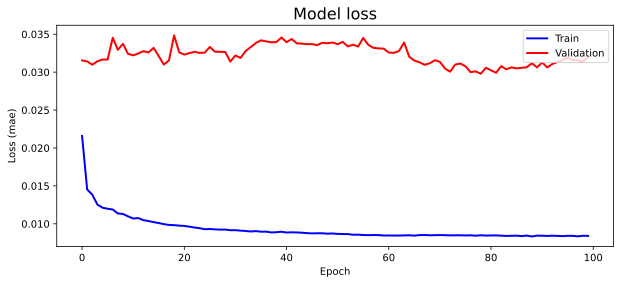

In [31]:
# sns.set(color_codes=True)

# plot the training and validation losses
fig, ax = plt.subplots(figsize=(10, 4), dpi=80)

ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
#ax.set_ylim([0, 0.04])
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')

plt.show()

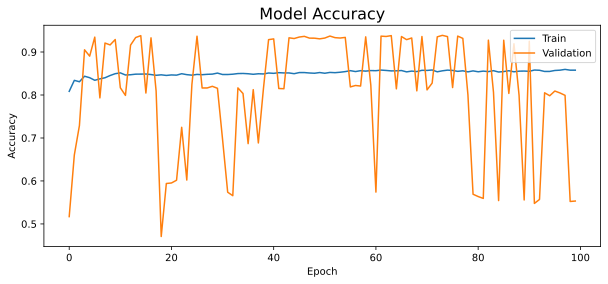

In [32]:
# plot the training and validation accuracys
fig, ax = plt.subplots(figsize=(10, 4), dpi=80)
ax.plot(history['accuracy'], label='Train')
ax.plot(history['val_accuracy'], label='Validation')
ax.set_title('Model Accuracy', fontsize=16)
ax.set_ylabel('Accuracy')
#ax.set_ylim([0.45, 1.05])
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')

plt.show()

#### Predict on X_train

In [33]:
train_start = time.time()

if model_loaded:
    X_pred_train = lstm_model.predict(X_train)
else:
    X_pred_train = model.predict(X_train)

train_end = time.time()
train_time = train_end - train_start
print(f"Training time: {train_time:.2f}s")

11021/11021 [==============================] - 16s 1ms/step
Training time: 20.28s


In [34]:
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=df_sw_benign.columns)
X_pred_train.index = pd.RangeIndex.from_range(range(0, len(X_train_AE)))

scored_train = pd.DataFrame(index=pd.RangeIndex.from_range(range(0, len(X_train_AE))))
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])

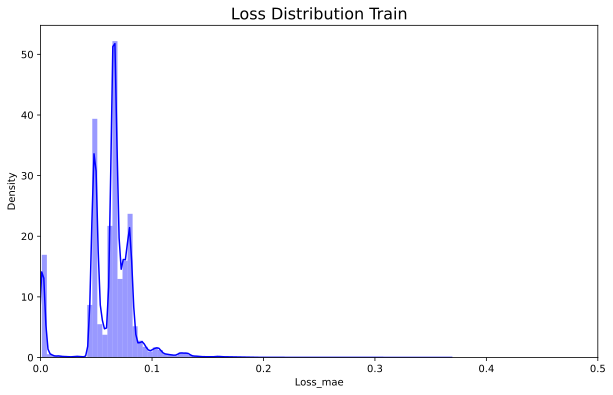

In [35]:
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train - Xtrain), axis = 1)
plt.figure(figsize=(10, 6), dpi=80)
plt.title("Loss Distribution Train", fontsize=16)

sns.distplot(scored_train['Loss_mae'], bins = 80, kde=True, color='blue');

plt.xlim([0.0, .5]);

In [36]:
# threshold = 0.09 # threshold from loss_mae plot above   ***
threshold = np.quantile(scored_train['Loss_mae'], 0.95)
print(threshold)

scored_train['Threshold'] = threshold
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']

0.09107424507651884


In [37]:
scored_train['Anomaly'].value_counts()

Anomaly
False    335010
True      17633
Name: count, dtype: int64

In [38]:
target_names = ['Benign', 'Attack']

print(f"Training time: {train_time / 60:.2f} min")
print(classification_report(X_train_label, scored_train['Anomaly'], target_names=target_names, digits = 5))

Training time: 0.34 min
              precision    recall  f1-score   support

      Benign    1.00000   0.95000   0.97436    352643
      Attack    0.00000   0.00000   0.00000         0

    accuracy                        0.95000    352643
   macro avg    0.50000   0.47500   0.48718    352643
weighted avg    1.00000   0.95000   0.97436    352643



In [39]:
# Percentage of attacks predicted in training data
print(f"Attacks Predicted: {np.count_nonzero(scored_train['Anomaly']==1) / len(scored_train['Anomaly']):.6f}")

Attacks Predicted: 0.050002


#### Predicao somente com dados Benignos (30%) == Cenário Normal

In [40]:
Xtest_benign = X_test_benign.reshape(X_test_benign.shape[0], 1, X_test_benign.shape[1])

test_start = time.time()

if model_loaded:
    X_pred_LSTM_ = lstm_model.predict(Xtest_benign)
else:
    X_pred_LSTM_ = model.predict(Xtest_benign)

test_end = time.time()
test_time = test_end - test_start
print(f"Testing time: {test_time:.2f}s\n")

5212/5212 [==============================] - 8s 2ms/step
Testing time: 10.64s



In [41]:
X_pred_test_benign = X_pred_LSTM_.reshape(X_pred_LSTM_.shape[0], X_pred_LSTM_.shape[2])
X_pred_test_benign = pd.DataFrame(X_pred_test_benign, columns=df_sw_benign.columns)
X_pred_test_benign.index = pd.RangeIndex.from_range(range(0, len(X_test_benign))) # cria um objeto RangeIndex do tam de X_test_AE

scored_test_benign = pd.DataFrame(index=pd.RangeIndex.from_range(range(0, len(X_test_benign))))

Xtest_benign = Xtest_benign.reshape(Xtest_benign.shape[0], Xtest_benign.shape[2])

In [42]:
# calculate the loss on the test set
scored_test_benign['Loss_mae'] = np.mean(np.abs(X_pred_test_benign - Xtest_benign), axis = 1)    # error vector in testing data
scored_test_benign['Threshold'] = threshold
scored_test_benign['Anomaly'] = scored_test_benign['Loss_mae'] > scored_test_benign['Threshold'] # if > then == attack

In [43]:
scored_test_benign.head(10)

,Loss_mae,Threshold,Anomaly
0,0.069983,0.091074,False
1,0.113978,0.091074,True
2,0.182516,0.091074,True
3,0.078173,0.091074,False
4,0.081123,0.091074,False
5,0.079617,0.091074,False
6,0.079120,0.091074,False
7,0.080085,0.091074,False
8,0.082644,0.091074,False
9,0.079993,0.091074,False


In [44]:
# Percentage of attacks predicted
print(f"Attacks Predicted (only benign): {np.count_nonzero(scored_test_benign['Anomaly']==1) / len(scored_test_benign['Anomaly']):.6f}")

Attacks Predicted (only benign): 0.040346


##### Majority Vote

In [45]:
# Assuming you have the reconstruction errors stored in a 
# list or numpy array called 'reconstruction_errors' and 'threshold'
# represents the threshold value for determining anomalies.

window_size = 96  # Size of the Sliding Window

def detect_anomalies_with_sliding_window(reconstruction_errors, threshold):
    num_samples = len(reconstruction_errors)
    anomaly_labels = np.zeros(num_samples)  # Initialize the anomaly labels
    
    for i in range(0, num_samples, window_size):
        # print(i)
        window_errors = reconstruction_errors[i:i+window_size]
        # print(window_errors)
        
        # If the majority of errors in the window exceed the threshold, label the window as anomalous
        if sum(i > threshold for i in window_errors) > (len(window_errors) / 2):
            anomaly_labels[i:i+window_size] = 1
    
    return anomaly_labels

anomaly_labels = detect_anomalies_with_sliding_window(scored_test_benign['Anomaly'], threshold)
# print(f'\n\nAnomaly: {anomaly_labels}')

print(np.unique(scored_test_benign['Anomaly'], return_counts=True))
np.unique(anomaly_labels, return_counts=True)

(array([False,  True]), array([160055,   6729]))


(array([0., 1.]), array([165824,    960]))

##### Metrics with Majority Vote

In [47]:
print(f"Testing time: {test_time / 60:.2f} min")
print(classification_report(np.zeros(len(anomaly_labels)), anomaly_labels, target_names=target_names, digits = 5))

Testing time: 0.18 min
              precision    recall  f1-score   support

      Benign    1.00000   0.99424   0.99711    166784
      Attack    0.00000   0.00000   0.00000         0

    accuracy                        0.99424    166784
   macro avg    0.50000   0.49712   0.49856    166784
weighted avg    1.00000   0.99424   0.99711    166784



[[165824    960]
 [     0      0]]


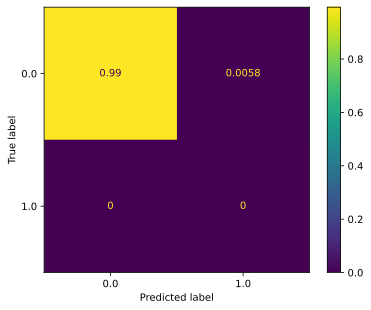

In [48]:
print(confusion_matrix(np.zeros(len(anomaly_labels)), anomaly_labels))
ConfusionMatrixDisplay.from_predictions(np.zeros(len(anomaly_labels)), anomaly_labels, normalize='all')

plt.show()

In [ ]:
print(f"Attacks Predicted using Sliding Window: {np.count_nonzero(anomaly_labels==1) / len(anomaly_labels):.6f}")

Attacks Predicted using Sliding Window: 0.005756


## 3.3 Test

#### Predicao com dados Benignos (30%) + Ataques (70%) == Cenário sob Ataque

In [49]:
# Predict on test data
test_start = time.time()

if model_loaded:
    X_pred_test = lstm_model.predict(X_test)
else:
    X_pred_test = model.predict(X_test)

test_end = time.time()
test_time = test_end - test_start
print(f"Testing Time: {test_time:.2f}s")

    27/208546 [..............................] - ETA: 6:57   

2023-06-22 09:58:56.337525: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 613958136 exceeds 10% of free system memory.


208546/208546 [==============================] - 305s 1ms/step


2023-06-22 10:05:35.284799: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 613958136 exceeds 10% of free system memory.


Testing Time: 400.14s


In [50]:
X_pred_test = X_pred_test.reshape(X_pred_test.shape[0], X_pred_test.shape[2])
X_pred_test = pd.DataFrame(X_pred_test, columns=df_sw_benign.columns)
X_pred_test.index = pd.RangeIndex.from_range(range(0, len(X_test_AE))) # cria um objeto RangeIndex do tam de X_test_AE

scored_test = pd.DataFrame(index=pd.RangeIndex.from_range(range(0, len(X_test_AE))))
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])

In [51]:
# calculate the loss on the test set
scored_test['Loss_mae'] = np.mean(np.abs(X_pred_test - Xtest), axis = 1)    # error vector in testing data
scored_test['Threshold'] = threshold
scored_test['Anomaly'] = scored_test['Loss_mae'] > scored_test['Threshold'] # if > then == attack

scored_test.head(10)

,Loss_mae,Threshold,Anomaly
0,0.069983,0.091074,False
1,0.113978,0.091074,True
2,0.182516,0.091074,True
3,0.078173,0.091074,False
4,0.081123,0.091074,False
5,0.079617,0.091074,False
6,0.079120,0.091074,False
7,0.080085,0.091074,False
8,0.082644,0.091074,False
9,0.079993,0.091074,False


### 3.4 Metrics without Sliding Window

In [52]:
# Quantidade real de dados benignos e de ataque no teste
print(np.unique(Y_test_AE, return_counts=True))

scored_test['Anomaly'].value_counts()

(array([0., 1.]), array([ 166784, 6506674]))


Anomaly
True     6506112
False     167346
Name: count, dtype: int64

In [53]:
print(f"Testing time: {test_time / 60:.2f} min")
print(classification_report(Y_test_AE, scored_test['Anomaly'], target_names=target_names, digits = 5))

Testing time: 6.67 min
              precision    recall  f1-score   support

      Benign    0.95643   0.95965   0.95804    166784
      Attack    0.99897   0.99888   0.99892   6506674

    accuracy                        0.99790   6673458
   macro avg    0.97770   0.97927   0.97848   6673458
weighted avg    0.99790   0.99790   0.99790   6673458



[[ 160055    6729]
 [   7291 6499383]]


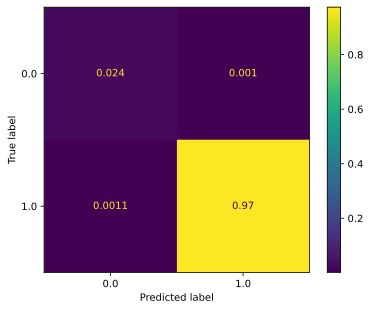

In [54]:
print(confusion_matrix(Y_test_AE, scored_test['Anomaly']))
ConfusionMatrixDisplay.from_predictions(Y_test_AE, scored_test['Anomaly'], normalize='all')

plt.show()

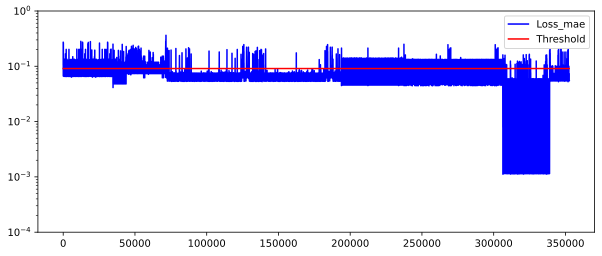

In [55]:
scored_train.plot(logy=True, figsize=(10,4), ylim=[1e-4, 1e0], color=['blue', 'red'], kind='line')
plt.show()

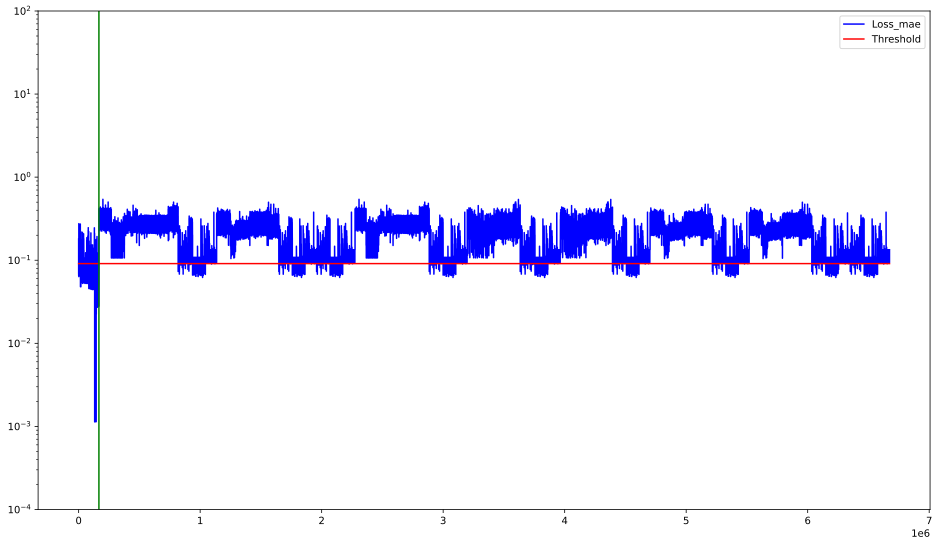

In [56]:
scored_test.plot(logy=True, figsize=(16,9), ylim=[1e-4, 1e2], color=['blue', 'red'], kind='line')
plt.axvline(len(X_test_benign), color='green')

plt.show()

### Majority Vote

In [57]:
threshold, window_size

(0.09107424507651884, 96)

In [ ]:
'''
(array([0., 1.]), array([ 166784, 6506674]))
'''

In [58]:
anomaly_labels_ = detect_anomalies_with_sliding_window(scored_test['Anomaly'], threshold)

print(np.unique(scored_test['Anomaly'], return_counts=True))
np.unique(anomaly_labels_, return_counts=True)

(array([False,  True]), array([ 167346, 6506112]))


(array([0., 1.]), array([ 170304, 6503154]))

In [61]:
print(classification_report(Y_test_AE, anomaly_labels_, target_names=target_names, digits = 5))

              precision    recall  f1-score   support

      Benign    0.97351   0.99405   0.98367    166784
      Attack    0.99985   0.99931   0.99958   6506674

    accuracy                        0.99918   6673458
   macro avg    0.98668   0.99668   0.99162   6673458
weighted avg    0.99919   0.99918   0.99918   6673458



[[ 165792     992]
 [   4512 6502162]]


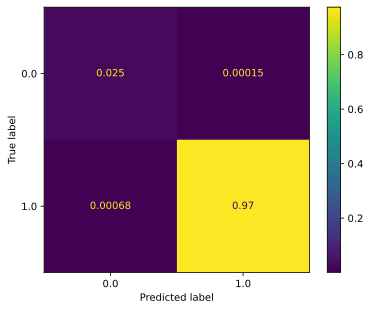

In [62]:
print(confusion_matrix(Y_test_AE, anomaly_labels_))
ConfusionMatrixDisplay.from_predictions(Y_test_AE, anomaly_labels_, normalize='all')

plt.show()